A random forest is a composistion of decision trees. A decision tree is what it sounds like. Each node can be split into further nodes based on some criteria. Ideally each leaf node would give certainty about the catagory of the dependent variable.

We will start by creating an algorithm for training decision trees. First we will generate some test data. Let there be three different categories: A, B and C. These are distributed based on the continuous variables x and y. Let them be bivariate normally distributed as such:

A ~ N(u_A,o_A)

B ~ N(u_B,o_B)

C ~ N(u_C,o_C)

Where u_i is a two-dimensional vector representing the mean and o_i is the covariance matrix. Both of category i. For simplicicty I will assume x and y are independent draws, i.e. the covariance between x and y is zero. Thus the x and y coordinate can be independetly drawn from a normal distribution.

I'm assuming each category has a probability of being generated: f_i. With F_A + F_B + F_C = 1.

Of course, other ways of gernerating test data are possible. Or other data sets can be used that are generated in an unknown manner.

In [95]:
import numpy as np
import random
import pandas as pd

In [96]:
#Number of draws
N = 100

#categories
cat = ['A', 'B', 'C']

# frequencies of categories
F_A = .2
F_B = .5
F_C = .3
F = [F_A, F_B, F_C]

#means
u_A = [1,3]
u_B = [5,3]
u_C = [2,-5]
u=[u_A, u_B, u_C]

#standard deviations
o_A = [1,1]
o_B = [1,1]
o_C = [1,1]
o=[o_A, o_B, o_C]

#dictionary
Pdict = {"A":0,"B":1,"C":2}

In [97]:
#Function for randomly generating / drawing a category

def draw_cat(F):
    r = random.uniform(0,1)
    for i in range(len(F)):
        if r < np.cumsum(F)[i]:
            c = cat[i]
            break
    return c

In [98]:
df = pd.DataFrame([], columns = ['x', 'y','category']) 

for i in range(100):
    draw = draw_cat(F)
    mean = u[Pdict[draw]]
    sigma = o[Pdict[draw]]
    x = np.random.normal(mean[0],sigma[0])
    y = np.random.normal(mean[1],sigma[1])
    df.loc[i] = [x,y,draw]



In [99]:
df.head()

,x,y,category
0,5.362409,4.515618,B
1,0.875913,1.306923,A
2,1.781765,-5.114854,C
3,1.456826,-3.295105,C
4,0.628139,1.579673,A


In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

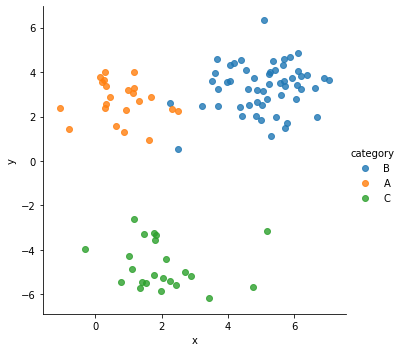

In [101]:
vis = sns.lmplot(data = df, x= 'x',y = 'y' , fit_reg=False , hue = 'category')

To start we'll try making a regular decision tree. Decisions will be restricted to the type x<=.. , y<=.. There will be no restrictions on the depth of the tree. 

At each node the optimal decision will be assigned. Based on either of these 2 metrics:

1. Gini Imputity (https://victorzhou.com/blog/gini-impurity/)

If we have C total classes and p(i) is the probability of picking a datapoint with class i, then the Gini Impurity is calculated as

G = \sum_{i=1}^C  p(i) * (1 - p(i))

Where G  is calculated for a certain branch. We’ll determine the quality of a split by weighting the impurity of each branch by how many elements it has.

2. Information gain

<<To be added later.>>

In [102]:
#Function for calculating the Gini Impurity

def GiniImpurity (values):
    values = list(values)
    GiniImp = 0
    cat = np.unique(values)
    total = len(values)
    for i in cat:
        p_i = values.count(i)/total
        GiniImp = GiniImp + p_i * (1-p_i)
    return(GiniImp)

In [103]:
GiniImpurity(df['category'])

0.5962000000000001

In [104]:
#Function for finding the gini impurity for every two-way split of a sorted list of categorical data

def FindGiniImpurityList(list):
    WeightedGiniImpurityList = []
    nr_of_data_points = len(list)
    for i in range(1,nr_of_data_points):
        A = list[0:i]
        B = list[i:nr_of_data_points]
        WeightedGiniImpurity = (GiniImpurity(A) * len(A) + GiniImpurity(B) * len(B))/nr_of_data_points
        WeightedGiniImpurityList.append(WeightedGiniImpurity)
    return(WeightedGiniImpurityList)


#Function for finding the best possible split. Return the variable v (x or y), threshold h: v<=h and gini impurity for split v<=h.

def FindBestSplit (data):
    nr_of_data_points = len(data)
    
    #create lists of category sorted by x or y
    sortbyx = list(data.sort_values('x')['category'])
    sortbyy = list(data.sort_values('y')['category'])
    
    #create sorted lists of x,y variables
    x_sorted = list(data.sort_values('x')['x'])
    y_sorted = list(data.sort_values('y')['y'])

    #create lists of GiniImpurity varying thourgh x/y
    WeightedGiniImpurityX = FindGiniImpurityList(sortbyx)
    WeightedGiniImpurityY = FindGiniImpurityList(sortbyy)
  
    WeightedGiniImpurityX = np.asarray(WeightedGiniImpurityX)
    WeightedGiniImpurityY = np.asarray(WeightedGiniImpurityY)
    
    argmin_x = WeightedGiniImpurityX.argmin()
    argmin_y = WeightedGiniImpurityY.argmin()
    
    MinGiniX = WeightedGiniImpurityX[argmin_x]
    MinGiniY = WeightedGiniImpurityY[argmin_y]
    
    best_x = x_sorted[argmin_x]
    best_y = y_sorted[argmin_y]
    
    if (MinGiniY <= MinGiniX):
        return(['y',best_y,MinGiniY])
    else:
        return(['x',best_x,MinGiniX])
    

In [114]:
#Iterative function for generating a decision tree using a greedy algorith based on the Gini Impurity

def split (data,depth):
    if len(data.category.value_counts()) ==1:
        return list(data['category'])[0]
    else:
        bestSplit = FindBestSplit(data)
        left = data[data[bestSplit[0]] <= bestSplit[1]]
        left_return = split(left,depth+1)
        right = data[data[bestSplit[0]] > bestSplit[1]]
        right_return = split(right,depth+1)
        return([[bestSplit[0],bestSplit[1]],[left_return,right_return]])
    

In [115]:
decisionTree1 = split(df,0)

In [116]:
print(FindBestSplit(df))
decisionTree1

['x', 2.875240268335989, 0.2949675324675325]


[['x', 2.875240268335989],
 [[['y', -2.597150350244715],
   ['C',
    [['y', 0.5450261231522164],
     ['B',
      [['x', 1.6669582833934862],
       ['A', [['y', 2.3551709612944896], ['A', 'B']]]]]]]],
  [['y', -3.1337211379262717], ['C', 'B']]]]

In [117]:
#Function for classifying data based on a decision tree

def classify (data, tree):
    if len(tree[0])==1:
        output = data
        output['category'] = tree[0]
    else:
        var = tree[0][0]
        val = tree[0][1]
        left_data = data[data[var]<=val]
        right_data = data[data[var]>val]
        left_output = classify(left_data,tree[1][0])
        right_output = classify(right_data,tree[1][1])
        merged = pd.concat([left_output,right_output])
        output = merged.sort_index()
    return(output)
        
    

In [118]:
test_df = df[['x','y']]
generated_df = classify(test_df,decisionTree1)

C:\Users\Gebruiker\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Gebruiker\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [119]:
generated_df == df

,x,y,category
0,True,True,True
1,True,True,True
2,True,True,True
3,True,True,True
4,True,True,True
5,True,True,True
6,True,True,True
7,True,True,True
8,True,True,True
9,True,True,True


In [120]:
#generate another set of data to test prediciton of the algorithm

df2 = pd.DataFrame([], columns = ['x', 'y','category']) 

for i in range(100):
    draw = draw_cat(F)
    mean = u[Pdict[draw]]
    sigma = o[Pdict[draw]]
    x = np.random.normal(mean[0],sigma[0])
    y = np.random.normal(mean[1],sigma[1])
    df2.loc[i] = [x,y,draw]

In [121]:
test_df2 = df2[['x','y']]
generated_df2 = classify(test_df2,decisionTree1)

C:\Users\Gebruiker\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Gebruiker\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [125]:
#fraction of succesful predictions
sum(generated_df2['category'] == df2['category'])/100

0.97